# Laboratorio #4 – Familias de Malware
### Jose Hernandez 20053
### Javier Mombiela 20067

## Parte 1 
### Creacion del dataset

In [70]:
# importando librerias
import os
import pefile
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [71]:
# ruta del malware
malware_dir = './MALWR'
malware_data = []

# iteramos sobre los archivos de malware
for malware in os.listdir(malware_dir):
    malwarepath = os.path.join(malware_dir, malware)
    
    if os.path.isfile(malwarepath):
        # analisis con pefile
        try:
            pe = pefile.PE(malwarepath)

            # Si el archivo no es un PE, se ignora
            if not pe.is_exe():
                continue
            
            # encontrando las caracteristicas del malware
            characteristics = pe.FILE_HEADER.Characteristics
            machine = pe.FILE_HEADER.Machine
            number_of_sections = pe.FILE_HEADER.NumberOfSections
            sections = [section.Name.decode().strip('\x00') for section in pe.sections]

            # funciones
            imports = []
            if hasattr(pe, 'DIRECTORY_ENTRY_IMPORT'):
                for entry in pe.DIRECTORY_ENTRY_IMPORT:
                    for imp in entry.imports:
                        imports.append(imp.name)

            # recursos
            resources = []
            if hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE'):
                for entry in pe.DIRECTORY_ENTRY_RESOURCE.entries:
                    resources.append(entry.name)

            # firmas digitales
            digital_signatures = pe.OPTIONAL_HEADER.DATA_DIRECTORY[pefile.DIRECTORY_ENTRY['IMAGE_DIRECTORY_ENTRY_SECURITY']].Size != 0

            # agregamos todas las caracteristicas a la lista de malware
            malware_data.append({
                'Filename': malware,
                "Machine": machine,
                "Characteristics": characteristics,
                "Number_of_sections": number_of_sections,
                "Sections": sections,
                "Imports": imports,
                "Resources": resources,
                "Digital_signatures": digital_signatures
            })

        except Exception as e:
            print(f"Error al analizar '{malware}': {e}")

Error al analizar '.DS_Store': 'DOS Header magic not found.'


In [72]:
# creamos un pandas dataset a partir de la lista de malware
df = pd.DataFrame(malware_data)
df.to_csv("malware.csv", index=False)

df.head()

,Filename,Machine,Characteristics,Number_of_sections,Sections,Imports,Resources,Digital_signatures
0,785003A405BC7A4EBCBB21DDB757BF3F,332,271,3,"[UPX0, UPX1, .rsrc]","[b'LoadLibraryA', b'ExitProcess', b'GetProcAdd...",[None],False
1,1F2EB7B090018D975E6D9B40868C94CA,332,271,3,"[UPX0, UPX1, .rsrc]","[b'LoadLibraryA', b'ExitProcess', b'GetProcAdd...",[None],False
2,FGJKJJ1_2BA0D0083976A5C1E3315413CDCFFCD2,332,271,3,"[UPX0, UPX1, .rsrc]","[b'LoadLibraryA', b'ExitProcess', b'GetProcAdd...",[None],False
3,RTC_7F85D7F628CE62D1D8F7B39D8940472,332,271,3,"[UPX0, UPX1, .rsrc]","[b'LoadLibraryA', b'ExitProcess', b'GetProcAdd...",[None],False
4,JH78C0A33A1B472A8C16123FD696A5CE5EBB,332,271,3,"[UPX0, UPX1, .rsrc]","[b'LoadLibraryA', b'ExitProcess', b'GetProcAdd...",[None],False


### Exploracion y pre procesamiento de datos

In [73]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Filename            35 non-null     object
 1   Machine             35 non-null     int64 
 2   Characteristics     35 non-null     int64 
 3   Number_of_sections  35 non-null     int64 
 4   Sections            35 non-null     object
 5   Imports             35 non-null     object
 6   Resources           35 non-null     object
 7   Digital_signatures  35 non-null     bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 2.1+ KB
None


In [74]:
print(df.describe())

       Machine  Characteristics  Number_of_sections
count     35.0             35.0           35.000000
mean     332.0            271.0            3.028571
std        0.0              0.0            0.169031
min      332.0            271.0            3.000000
25%      332.0            271.0            3.000000
50%      332.0            271.0            3.000000
75%      332.0            271.0            3.000000
max      332.0            271.0            4.000000


In [75]:
print(df.isnull().sum())

Filename              0
Machine               0
Characteristics       0
Number_of_sections    0
Sections              0
Imports               0
Resources             0
Digital_signatures    0
dtype: int64


In [76]:
# Convierte las listas en strings
df['Sections'] = df['Sections'].apply(lambda x: ', '.join(x))
df['Imports'] = df['Imports'].apply(lambda x: ', '.join([i.decode('utf-8') for i in x if i is not None]))
df['Resources'] = df['Resources'].apply(lambda x: ', '.join([i.decode('utf-8') for i in x if i is not None]))

df = pd.get_dummies(df)

scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

## Parte 2 
### Implementacion de modelos (K-means y DBSCAN)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering

In [78]:
# Definimos el rango de clusters a probar
max_clusters = 10

# Crea listas para almacenar los errores de cada número de clústeres
kmeans_errors = []

# Crea listas para almacenar los coeficientes de Silhouette de cada número de clústeres
kmeans_silhouettes = []

# Prueba diferentes números de clústeres
for num_clusters in range(1, max_clusters+1):
    # Crea el objeto KMeans
    kmeans = KMeans(n_clusters=num_clusters)

    # Ajusta el modelo a tus datos
    kmeans.fit(df)

    # Calcula el error cuadrático medio del modelo
    kmeans_errors.append(kmeans.inertia_)

    # Calcula el coeficiente de Silhouette del modelo
    if num_clusters > 1:  # El coeficiente de Silhouette no está definido para 1 clúster
        kmeans_silhouettes.append(silhouette_score(df, kmeans.labels_))

print(kmeans_errors)
print(kmeans_silhouettes)

[77.54285714285714, 58.29545454545456, 49.500000000000014, 46.41666666666667, 36.333333333333336, 37.44444444444445, 36.0, 28.333333333333336, 26.000000000000007, 26.333333333333332]
[0.25537290675387947, 0.29619343443811613, 0.170229850463744, 0.2636294507921782, 0.1322090149791735, 0.08196524175615287, 0.15730182850023575, 0.17658210064630261, 0.097877015379314]


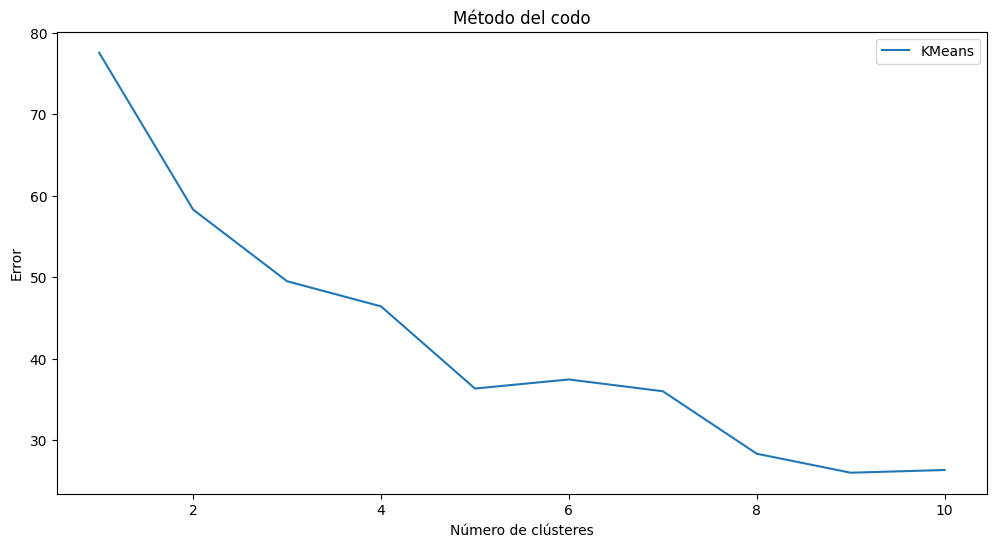

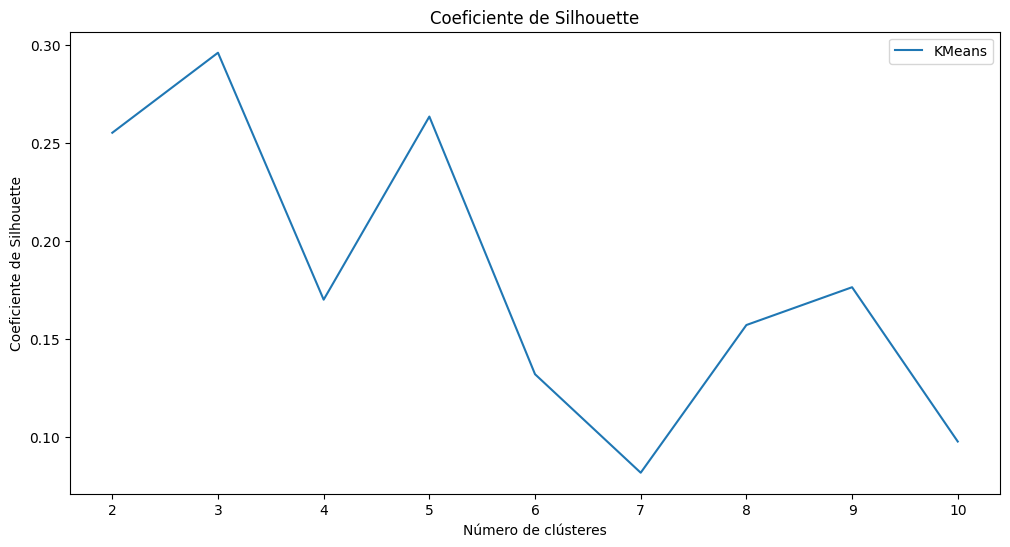

In [79]:
# Genera la gráfica del error contra K
plt.figure(figsize=(12, 6))
plt.plot(range(1, max_clusters+1), kmeans_errors, label='KMeans')
plt.title('Método del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('Error')
plt.legend()
plt.show()

# Genera la gráfica del coeficiente de Silhouette contra K
plt.figure(figsize=(12, 6))
plt.plot(range(2, max_clusters+1), kmeans_silhouettes, label='KMeans')  # El coeficiente de Silhouette no está definido para 1 clúster
plt.title('Coeficiente de Silhouette')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.legend()
plt.show()

In [80]:
# Crea listas para almacenar los coeficientes de Silhouette de cada número de clústeres
spectral_silhouettes = []

# Prueba diferentes números de clústeres
for num_clusters in range(2, max_clusters+1):  # El coeficiente de Silhouette no está definido para 1 clúster
    # Crea el objeto SpectralClustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors')

    # Ajusta el modelo a tus datos
    labels = spectral.fit_predict(df)

    # Calcula el coeficiente de Silhouette del modelo
    spectral_silhouettes.append(silhouette_score(df, labels))

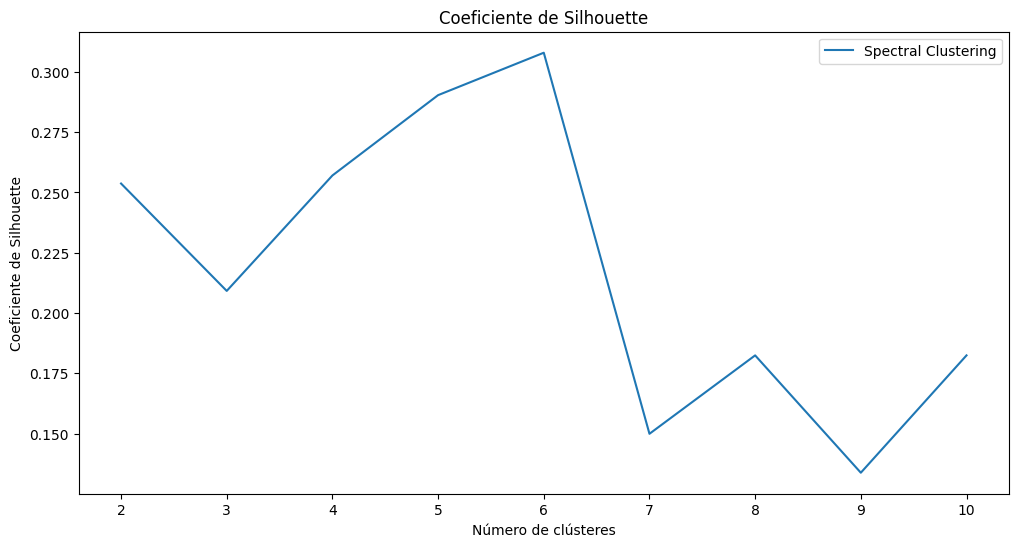

In [81]:
# Genera la gráfica del coeficiente de Silhouette contra K
plt.figure(figsize=(12, 6))
plt.plot(range(2, max_clusters+1), spectral_silhouettes, label='Spectral Clustering')
plt.title('Coeficiente de Silhouette')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de Silhouette')
plt.legend()
plt.show()